In [32]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#import keras
from tensorflow.keras import layers
from datetime import datetime
from pathlib import Path
import h5py as h5
import io
import os
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import calendar
from tensorflow.keras.backend import clear_session
import gc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models, losses, optimizers

In [33]:
def list_months_between(start_date:str, end_date:str):
    
    d1 =  datetime.strptime(start_date,'%Y%m%d')
    d2 =  datetime.strptime(end_date,'%Y%m%d')
    # List to store the year-month pairs
    months = []
    # Initialize the current date to the start date
    current_date = d1

    while current_date <= d2:
        # Append the current year and month to the list
        months.append((current_date.year, current_date.month))
       
        # Move to the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return months

In [34]:
def load_rain_data(rain_data_dir:str,start_date:str,end_date:str):

    days_leap = [31,29,31,30,31,30,31,31,30,31,30,31]
    days_noleap = [31,28,31,30,31,30,31,31,30,31,30,31]
    
    months = list_months_between(start_date, end_date)
    index = 0
    path = Path(rain_data_dir)
    rain_final = np.zeros((0,351,401),dtype=np.float32)
    days = 0
    for mnth in months:
        fl = os.path.join(rain_data_dir,str.format('GRAIN_%d%.2d.mat'%(mnth[0],mnth[1])))
        print(fl)
        if calendar.isleap(mnth[0]) == True:
            d1 =  datetime.strptime(str.format('%d%d%d'%(mnth[0],mnth[1],days_leap[mnth[1]-1])),'%Y%m%d')
        else :
            d1 =  datetime.strptime(str.format('%d%d%d'%(mnth[0],mnth[1],days_noleap[mnth[1]-1])),'%Y%m%d')
            
        days = days + d1.day
        
        f = h5.File(fl, "r")

        if index==0:
            glat = f.get("glat")[()]
            glon = f.get("glon")[()]

        rain = f.get("GRAIN")[()]
        #rain = rain[0:672,:,:]

        print(rain.max(),rain.min())
        rain_final = np.concatenate((rain_final,rain),axis=0)

        f.close()
    
    rain_final = rain_final.reshape((days,24,351,401)).astype(np.float16)
    print(f'days:{days}',rain_final.dtype) 
    return rain_final,glat,glon

In [35]:
# Normalize the data
def normalize(rain_final):
    scaler = MinMaxScaler()
    rain_final = scaler.fit_transform(rain_final.reshape(-1, rain_final.shape[-1])).reshape(rain_final.shape)

    return scaler,rain_final

In [36]:
def log_scale(data, epsilon=1e-6):
    """
    Apply log scaling to the data.
   
    :param data: Input data
    :param epsilon: Small value to avoid log(0)
    :return: Log-scaled data
    """
    return np.log(data + epsilon)

def inverse_log_scale(data, epsilon=1e-6):
    """
    Inverse of log scaling.
   
    :param data: Log-scaled data
    :param epsilon: Small value used in log scaling
    :return: Original scale data
    """
    return np.exp(data) - epsilon

In [47]:
# Download and load the dataset.
#fpath = keras.utils.get_file(
#    "moving_mnist.npy",
#    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
#)
dataset,glat,glon = load_rain_data('/home/intern/RAIN_DATA/RAJU_MAT','20220801','20220831')

#scaler,dataset    = normalize(dataset)
dataset    = log_scale(dataset)
print('minimum value: %f maximum value: %f '%(dataset.min(),dataset.max()))
# Swap the axes representing the number of frames and number of data samples.
#dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
#dataset = dataset[:10, ...]
print(dataset.shape,dataset.dtype)

dataset = dataset[:2,:,:,:]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)


# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
#train_dataset = train_dataset / 255
#val_dataset = val_dataset / 255


# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))


/home/intern/RAIN_DATA/RAJU_MAT/GRAIN_202208.mat
173.21914672851562 0.0
days:31 float16
minimum value: -13.804688 maximum value: 5.156250 
(31, 24, 351, 401) float16
Training Dataset Shapes: (1, 23, 351, 401, 1), (1, 23, 351, 401, 1)
Validation Dataset Shapes: (1, 23, 351, 401, 1), (1, 23, 351, 401, 1)


Displaying frames for example 0.


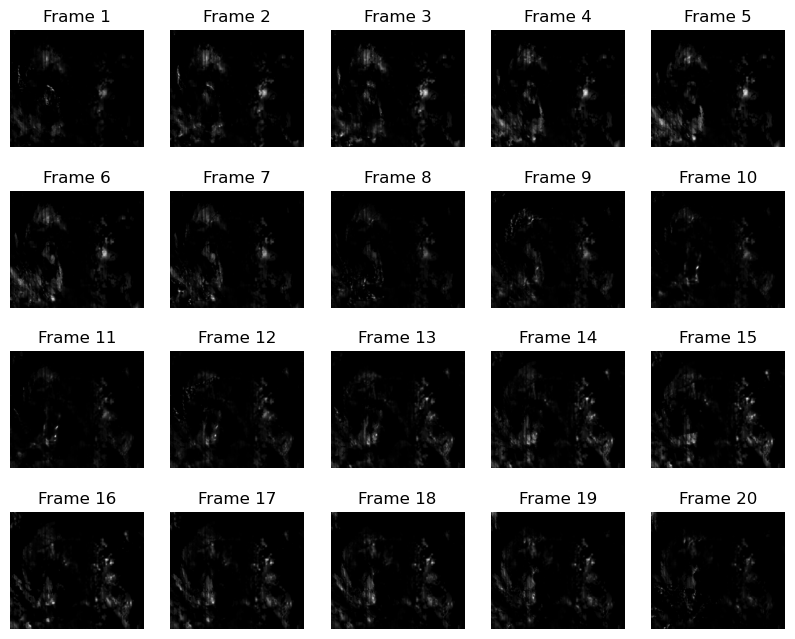

In [43]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [29]:
# # Construct the input layer with no definite frame size.
# inp = layers.Input(shape=(None, *x_train.shape[2:]))

# # We will construct 3 `ConvLSTM2D` layers with batch normalization,
# # followed by a `Conv3D` layer for the spatiotemporal outputs.
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(5, 5),
#     padding="same",
#     return_sequences=True,
#     activation='relu',
# )(inp)
# x = layers.BatchNormalization()(x)
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(3, 3),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
# x = layers.BatchNormalization()(x)
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(1, 1),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
# x = layers.MaxPooling3D(pool_size=(1,2,2), padding="same")(x)
# x = layers.UpSampling3D(size=(1,2,2))(x)
# x = layers.Cropping3D(cropping=((0,0),(0,1),(0,1)))(x)
# x = layers.Conv3D(
#     filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
# )(x)

# # Next, we will build the complete model and compile it.
# model = tf.keras.models.Model(inp, x)
# model.compile(
#     loss=tf.keras.losses.binary_crossentropy,
#     optimizer=tf.keras.optimizers.Adam(),
# )
# print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None, 351, 401, │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_9 (ConvLSTM2D)      │ (None, None, 351, 401, │       416,256 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, None, 351, 401, │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_10 (ConvLSTM2D)     │ (None, None, 351, 401, │       295,168 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, None, 351, 401, │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_11 (ConvLSTM2D)     │ (None, None, 351, 401, │        33,024 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, None, 176, 201, │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_3 (UpSampling3D)  │ (None, None, 352, 402, │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping3d_3 (Cropping3D)       │ (None, None, 351, 401, │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, None, 351, 401, │         1,729 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 746,689 (2.85 MB)

 Trainable params: 746,433 (2.85 MB)

 Non-trainable params: 256 (1.00 KB)

None


In [44]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.


In [20]:
# # Construct the input layer with no definite frame size.
# inp = layers.Input(shape=(None, *x_train.shape[2:]))

# # First ConvLSTM2D layer followed by BatchNormalization, MaxPooling3D, and UpSampling3D
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(5, 5),
#     padding="same",
#     return_sequences=True,
#     activation='relu',
# )(inp)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPooling3D(pool_size=(1, 2, 2), padding="same")(x)
# x = layers.UpSampling3D(size=(1, 2, 2))(x)
# x = layers.Cropping3D(cropping=((0,0),(0,1),(0,1)))(x)
# # Second ConvLSTM2D layer followed by BatchNormalization, MaxPooling3D, and UpSampling3D
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(3, 3),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPooling3D(pool_size=(1, 2, 2), padding="same")(x)
# x = layers.UpSampling3D(size=(1, 2, 2))(x)
# x = layers.Cropping3D(cropping=((0,0),(0,1),(0,1)))(x)
# # Third ConvLSTM2D layer followed by MaxPooling3D and UpSampling3D
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(1, 1),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
# x = layers.MaxPooling3D(pool_size=(1, 2, 2), padding="same")(x)
# x = layers.UpSampling3D(size=(1, 2, 2))(x)
# x = layers.Cropping3D(cropping=((0,0),(0,1),(0,1)))(x)
# # Final Conv3D layer
# x = layers.Conv3D(
#     filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
# )(x)

# # Next, we will build the complete model and compile it.
# model = tf.keras.models.Model(inp, x)
# model.compile(
#     loss=tf.keras.losses.binary_crossentropy,
#     optimizer=tf.keras.optimizers.Adam(),
# )

# # Print the model summary to verify the changes
# model.summary()

In [18]:
# # Construct the input layer with an indefinite frame size.
# # Assuming x_train has the shape (num_samples, time_steps, height, width, channels).
# inp = layers.Input(shape=(None, *x_train.shape[2:]))

# # First ConvLSTM2D layer with batch normalization and max pooling.
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(5, 5),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(inp)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)  # Pooling only spatial dimensions

# # Second ConvLSTM2D layer with batch normalization and max pooling.
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(3, 3),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)

# # Third ConvLSTM2D layer without batch normalization.
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(3, 3),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)

# # Conv3D layer to produce the final spatiotemporal output.
# x = layers.Conv3D(
#     filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
# )(x)

# # Build the complete model.
# model = models.Model(inp, x)

# # Compile the model with binary cross-entropy loss and Adam optimizer.
# model.compile(
#     loss=losses.binary_crossentropy,
#     optimizer=optimizers.Adam(),
# )

# # Print the model summary to verify the architecture.
# model.summary()

In [19]:
# # Construct the input layer with definite frame size for time_steps, height, width, and channels.
# inp = layers.Input(shape=(None, *x_train.shape[2:]))

# # First ConvLSTM2D layer with batch normalization and max pooling.
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(5, 5),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(inp)
# x = layers.BatchNormalization()(x)
# #x = layers.MaxPooling3D(pool_size=(1, 2, 2), padding="same")(x)  # Pooling only spatial dimensions

# # Second ConvLSTM2D layer with batch normalization and max pooling.
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(3, 3),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
# x = layers.BatchNormalization()(x)
# #x = layers.MaxPooling3D(pool_size=(1, 2, 2), padding="same")(x)

# # Third ConvLSTM2D layer with batch normalization.
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(3, 3),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
# x = layers.BatchNormalization()(x)

# # Fourth ConvLSTM2D layer without batch normalization.
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(1, 1),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)

# # Conv3D layer to produce the final spatiotemporal output.
# x = layers.Conv3D(
#     filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
# )(x)

# # Build the complete model.
# model = models.Model(inp, x)

# # Compile the model with binary cross-entropy loss and Adam optimizer.
# model.compile(
#     loss=losses.binary_crossentropy,
#     optimizer=optimizers.Adam(),
# )

# # Print the model summary to verify the architecture.
# model.summary()

In [45]:
# Define some callbacks to improve training.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 25
batch_size = 2
try:
    # Fit the model to the training data.
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, reduce_lr],
    )
except Exception as e:
    print(f"Exception occurred {e.args}")
    
#clear_session()
#del model
#gc.collect() 

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.7382 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6050 - val_loss: 0.6862 - learning_rate: 0.0010
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4018 - val_loss: 0.6821 - learning_rate: 0.0010
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2027 - val_loss: 0.6760 - learning_rate: 0.0010
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1384 - val_loss: 0.6653 - learning_rate: 0.0010
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0922 - val_loss: 0.6546 - learning_rate: 0.0010
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0895 - val_loss: 0.6415 - learning_rate: 0.0010
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0861 - val_loss: 0.6288 - learning_rate: 0.0010
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0788 - val_loss: 0.6146 - learning_rate: 0.0010
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
(351, 401, 1) 0.0 1.0
(351, 401, 1) 0.0 0.988
(351, 401, 1) 0.0 0.7373
(351, 401, 1) 0.0 0.542
(351, 401, 1) 0.0 0.5664
(351, 401, 1) 0.0 0.607
(351, 401, 1) 0.0 0.7437
(351, 401, 1) 0.0 0.892
(351, 401, 1) 0.0 0.99
(351, 401, 1) 0.0 1.0
0.38367406 0.44795778
0.33949462 0.44721222
0.26550823 0.4467496
0.15427516 0.44659165
0.04213981 0.44674388
0.0012683155 0.4471298
3.660929e-07 0.44769663
1.9639385e-18 0.4487647
2.14549e-35 0.45000553
0.0 0.45125663


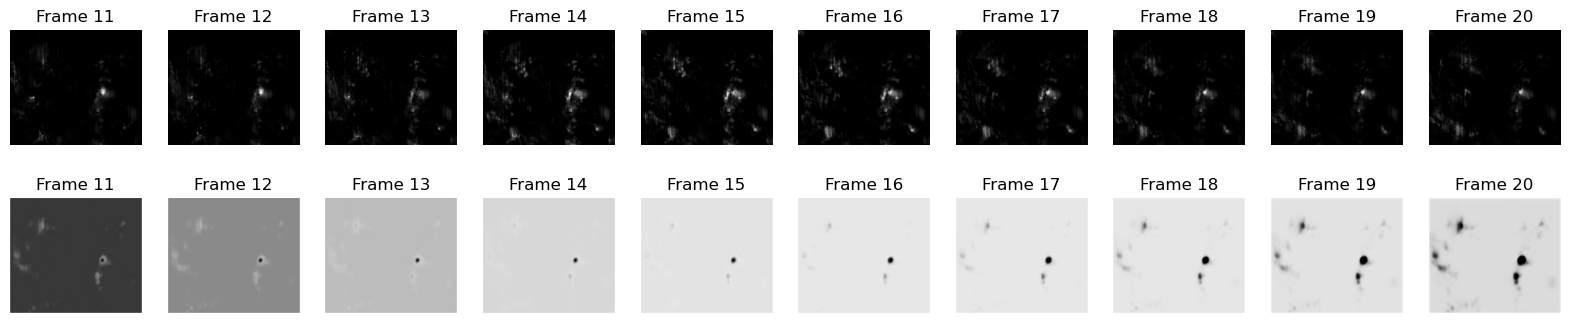

In [46]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]
#################################
# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

#model.predict(
# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction,axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    
    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    orig = original_frames[idx]
    print(orig.shape,orig.min(),orig.max())
    ax.imshow((np.squeeze(original_frames[idx])), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    img = new_frames[idx]
    #img[img == img.min()]=0
    #orig = original_frames[idx]
    #diff = orig - img
    #print('difference: ',diff.min(),diff.max())
    print(img.min(),img.max())
    #ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.imshow((np.squeeze(img)), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

In [ ]:
tf.compat.v1.reset_default_graph()

In [ ]:
def free_gpu_memory():
    # Clear session
    tf.keras.backend.clear_session()
    # Collect garbage
    gc.collect()
    # Reset memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, False)
        except RuntimeError as e:
            print(e)

# Assuming you have run some TensorFlow code
# Now free GPU memory
free_gpu_memory()